Modules and Packages

In [176]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import random
import pandas as pd
import loess
from loess import loess_1d
from matplotlib.pyplot import cm
from sklearn.metrics import explained_variance_score
import copy
from sklearn.decomposition import PCA, NMF
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import r2_score,mean_squared_error
import fastcluster as fc
from scipy.cluster.hierarchy import cophenet
from sklearn import preprocessing
from scipy.stats import spearmanr
import scipy
import multiprocessing
from matplotlib.backends.backend_pdf import PdfPages
import umap.umap_ as umap
import statsmodels
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as mcolors

sns.reset_orig()

install missing modules if any

In [5]:
!pip install loess
!pip install fastcluster
!pip install umap-learn
!pip install statsmodels
!pip install umap

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Import files

In [177]:
data=pd.read_csv("SD_network/NMF_Analysis/outputs/1MB/Duplicated_Regions_Final_1MB.csv")
ct_data=pd.read_csv("SD_network/NMF_Analysis/files/telocentro_hg38.bed",delimiter="\t",header=None)
data_chr=data[["chromosome_name","start","end"]] 
data.drop(["chromosome_name","start","end"],inplace=True,axis=1) 
pos=~(data==0).all(axis=1) 
data_nonzero=data.loc[~(data==0).all(axis=1)] 
data_nonzero.drop(['rRNA', 'snRNA', 'scRNA', 'srpRNA', 'tRNA', 'RC'],axis=1,inplace=True) 
scaler = preprocessing.MaxAbsScaler().fit(data_nonzero)
X_abs_scaler = scaler.transform(data_nonzero)

/scratch/local/ipykernel_46050/1512121586.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_nonzero.drop(['rRNA', 'snRNA', 'scRNA', 'srpRNA', 'tRNA', 'RC'],axis=1,inplace=True)


In [178]:
data.shape

(2810, 46)

In [179]:
data_nonzero

,length_0,length_1,jumps,gaps,genes,cpgisl_in,cpgisl_bor,repli_in,repli_bor,repli_bor_deriv,...,iner_degree,self_loops,edges_double,edges_tandem,edges_ident_mean_0,edges_ident_mean_1,CG_frac_0,CG_frac_1,CG_frac_in_0,CG_frac_in_1
1,1.0,1.0,2.0,0.0,0.0,0.0,0.0,4.0,4.0,4.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,1.0,1.0
2,3.0,1.0,6.0,0.0,4.0,0.0,0.0,230.0,231.0,236.0,...,3.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,1.0,3.0
3,3.0,1.0,4.0,0.0,4.0,0.0,0.0,284.0,284.0,287.0,...,4.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0
4,4.0,9.0,17.0,1.0,14.0,0.0,0.0,147.0,148.0,155.0,...,13.0,0.0,4.0,14.0,9.0,4.0,11.0,2.0,11.0,2.0
5,6.0,0.0,7.0,0.0,5.0,0.0,0.0,462.0,462.0,467.0,...,5.0,0.0,0.0,2.0,1.0,5.0,3.0,3.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,1.0,6.0,15.0,9.0,1.0,6.0,1.0,140.0,147.0,0.0,...,23.0,3.0,140.0,10.0,1.0,6.0,1.0,6.0,5.0,2.0
2806,0.0,1.0,2.0,1.0,0.0,3.0,1.0,20.0,21.0,0.0,...,8.0,2.0,97.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2807,0.0,3.0,6.0,5.0,0.0,1.0,1.0,60.0,63.0,0.0,...,0.0,0.0,5.0,2.0,0.0,3.0,0.0,3.0,2.0,1.0
2808,0.0,10.0,17.0,13.0,1.0,13.0,0.0,200.0,210.0,0.0,...,33.0,0.0,40.0,5.0,2.0,8.0,2.0,8.0,6.0,4.0


Multiple iterations of NMF with random matrix initialization

In [180]:
def get_scores_vs_s(matrix):

    """
    The function takes a matrix, performs NMF on it 
    and returns the error and fitted matrices for a range of values of no. 
    components.
    """
    scores=[]
    rcerror=[]
    r2error=[]
    exp_var_score=[]
    array_W_hat=[]
    array_H_hat=[]
    
    
    for i in range(1,30):
        
        model = NMF(n_components=i,max_iter=10000,init="random",tol=1e-4,beta_loss='kullback-leibler',solver="mu")
        W_hat = model.fit_transform(matrix)
        H_hat = model.components_
        
        scores.append( mean_squared_error(W_hat.dot(H_hat),matrix))
        rcerror.append(model.reconstruction_err_)
        r2error.append(r2_score(matrix,W_hat.dot(H_hat)))
        exp_var_score.append(explained_variance_score(matrix,W_hat.dot(H_hat)))
        
        array_W_hat.append(W_hat)
        array_H_hat.append(H_hat)
        
    return scores, rcerror, r2error,exp_var_score, array_W_hat, array_H_hat

In [163]:
res=[] 
for i in range(100):
    scores, rc_error, r2error, exp_var_score, W_hat, H_hat = get_scores_vs_s(np.array(X_abs_scaler))
    res.append([scores, rc_error, r2error, exp_var_score, W_hat, H_hat])

In [182]:
len(res)

100

We implement different functions to measure the quality of NMF, to find optimal k value.

1. Cophnetic correlation calculation

In [183]:
def consensus_matrix(runs, i, k):
    W_hat = copy.deepcopy(runs[i][4][k])
    no_samples = runs[i][4][k].shape[0]
    consensus_matrix = np.ones(shape=(no_samples, no_samples))
    clusters = np.argmax(runs[i][4][k], axis=1)
    
    for j in range(no_samples):
        for l in range(no_samples):
            if clusters[l] == clusters[j]:
                consensus_matrix[j][l] = 0.0
                
    return consensus_matrix

def calculate_consensus_matrix(runs, k):
    result = consensus_matrix(runs, 0, k)
    
    for i in range(0, 100):
        result += consensus_matrix(runs, i, k)
        
    result = result / 100
    
    Z = fc.linkage_vector(result)   
    orign_dists = fc.pdist(result)  
    cophe_dists = cophenet(Z)       
    corr_coef = np.corrcoef(orign_dists, cophe_dists)[0, 1] 
    
    return corr_coef

In [184]:
scores_corr=[]
for k in range(1,29):
    x=calculate_consensus_matrix(res,k)
    scores_corr.append(x)

2. BIC

In [185]:
def bic1(res):
    c=(40+294)/(40*294)
    scores=np.zeros(29)
    for i in res:
        for j in range(29):
            scores[j]+=np.log(i[0][j]) + (j+1)*c*np.log(1/c)
    scores=scores/100
    return scores

3. FYV

In [186]:
def fyv(res):
    scores=np.zeros(29)
    for i in res:
        for k in range(29):
            x=i[5][k]/np.sum(i[5][k],axis=0)
            scores[k]+=np.linalg.det(x.dot(x.transpose()))
    scores=scores/100
    return scores

4. Compare signatures from different runs

In [187]:
def compare_sigs(s1,s2):
    out=[]
    final_sim_score=0.0
    for i in range(len(s1)):
        corr=-10
        best=0
        for j in range(len(s2)):
            if np.corrcoef(s1[i],s2[j])[0][1]>corr:
                corr=np.corrcoef(s1[i],s2[j])[0][1]
                best=j
        out.append([i,best,corr])
        final_sim_score+=corr/(len(s1))
    
        
    return final_sim_score,out           

In [188]:
def compare_sigs(s1,s2):
    edges={}
    matches=[]
    sim_score=0.0
    for i in range(len(s1)):
        corr=-10
        for j in range(len(s2)):
            corr=np.corrcoef(s1[i],s2[j])[0][1]
            edges[(i,j)]=corr
            
    for i in range(len(s1)):
        v = list(edges.values())
        k = list(edges.keys())
        best=k[v.index(max(v))]
        matches.append(best)
        
        for j in range(len(s2)):
            edges.pop((best[0],j), None)
            edges.pop((j,best[1]), None)
           
    for i in matches:
        sim_score+=np.corrcoef(s1[i[0]],s2[i[1]])[0][1]
    
    return sim_score/len(s1)

5. Explain variance

In [189]:
explain_var=np.zeros(29)
for i in res:
    explain_var+=np.array(i[3])
explain_var=explain_var/100

6. reconstruction score

In [190]:
rc_score=np.zeros(29)
for i in res:
    rc_score+=np.array(i[1])
rc_score=rc_score/100  

7. Stability of prediction

In [191]:
def get_stability_of_prediction(res):
    stability_of_prediction=[]
    for k in range(0,29):
        signatures=[]
        for i in range(100):
            signatures.append(res[i][5][k])
        final_score=0.0
        for i in signatures[1:]:
            final_score+=compare_sigs(signatures[0],i)
        stability_of_prediction.append(final_score/100)
    return(stability_of_prediction)

In [192]:
stability_of_prediction = get_stability_of_prediction(res)

7. Imputation of data, then measure MSE of NMF reconstructed data matrix from original data matrix.

In [193]:
def imputation(data):
    arr=scipy.sparse.rand(1975, 40, density=0.9).toarray()
    arr[arr!=0.0]=1.0
    
    scaler = preprocessing.MaxAbsScaler().fit(data)
    X_abs_scaler1 = scaler.transform(data)
    A=np.multiply(arr,X_abs_scaler1)
    
    scores, rc_error, r2error, exp_var_score, W_hat, H_hat = get_scores_vs_s(A)
    
    scores=np.zeros(len(W_hat))
    for i in range(len(W_hat)):
        pred=W_hat[i].dot(H_hat[i])
        scores[i]=mean_squared_error(np.multiply(pred,1-arr),np.multiply(1-arr,X_abs_scaler1))
    
    return scores

In [194]:
imputation_res=imputation(X_abs_scaler)

 Visualization of NMF performance for different k values.

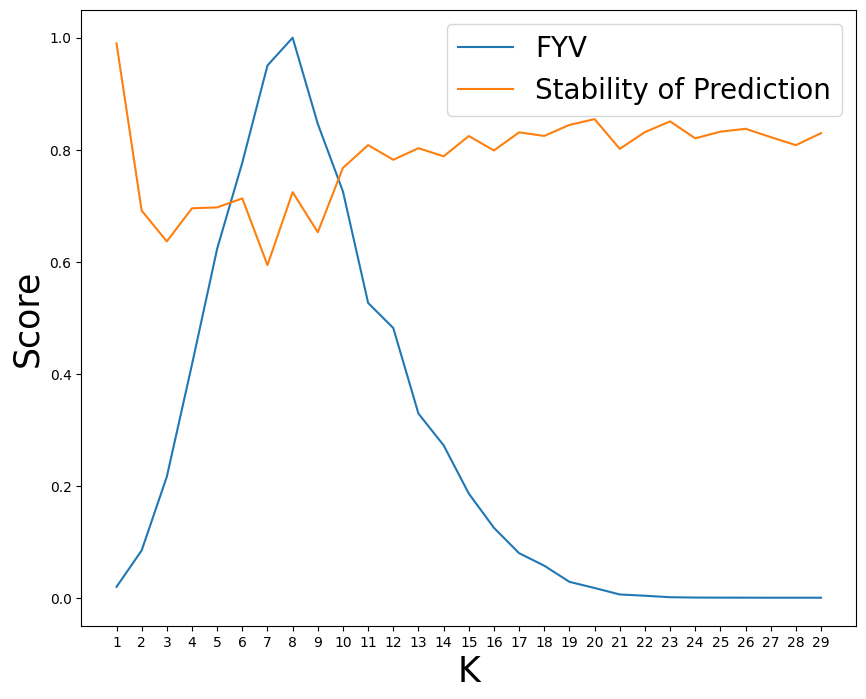

In [281]:
plt.figure(figsize=(10,8))
# plt.plot(imputation_res/max(imputation_res),label="Imputation result")
# plt.plot(scores_corr,label="Cophnetic correlation")
# plt.plot(explain_var,label="Explained_Variance")
# plt.plot(rc_score/max(rc_score),label="Reconstruction Score")


plt.plot(np.arange(1,30),fyv(res)/max(fyv(res)),label="FYV")
plt.plot(np.arange(1,30),stability_of_prediction,label="Stability of Prediction")
plt.xticks(np.arange(1,30))


plt.legend(fontsize=20)
plt.xlabel("K",fontsize=25)
plt.ylabel("Score",fontsize=25)

plt.savefig("SD_network/NMF_Analysis/outputs/1MB/best_k.pdf",format="pdf")

plt.show()


Now we know the optimal number of signatures and then procede to analyze these signatures(obtained from NMF). We want to analyze how these signatures affect segments, depending on segment location ie. pericentromic, subtelomeric. How with increasing distance from a centromere/telomere the signature's contribution to segmental duplications changes.

Finding nearest centromere or telomere 

In [196]:
def find_nearest_ct(split_data, ct_data):
    """
    Finds the nearest centromere or telomere to each data point in split_data.

    Args:
        split_data (DataFrame): Dataframe containing chromosome_name, start, and end columns.
        ct_data (DataFrame): Dataframe containing centromere and telomere data.

    Returns:
        c (list): List of centromere distances.
        t (list): List of telomere distances.
        m (list): List of markers indicating whether the nearest feature is a centromere ('c') or telomere ('t').
    """
    c = []
    t = []
    m = []

    for i in range(2810):
        chromosome_name = split_data.loc[i]["chromosome_name"]
        start = split_data.loc[i]["start"]
        end = split_data.loc[i]["end"]

        # Find centromere and telomere data for the chromosome
        ct = ct_data[ct_data[0] == "chr" + str(int(chromosome_name))]
        ct_telomere = ct[ct[3] == "telomere"]
        ct_centromere = ct[ct[3] == "centromere"]

        telomere_dist = 0
        centromere_dist = 0

        # Calculate distance to nearest telomere
        point_1 = ct_telomere.iloc[0][2]
        point_2 = ct_telomere.iloc[1][1]

        if np.abs(start - point_1) < np.abs(end - point_2):
            telomere_dist = np.abs(start - point_1)
        else:
            telomere_dist = np.abs(end - point_2)

        # Calculate distance to nearest centromere
        point_1 = ct_centromere.iloc[0][1]
        point_2 = ct_centromere.iloc[1][2]

        if np.abs(end - point_1) < np.abs(start - point_2):
            centromere_dist = np.abs(end - point_1)
        else:
            centromere_dist = np.abs(start - point_2)

        # Determine if nearest feature is a centromere or telomere
        if telomere_dist > centromere_dist:
            m.append("c")
        else:
            m.append("t")

        t.append(telomere_dist)
        c.append(centromere_dist)

    return c, t, m


# Call the find_nearest_ct function to calculate the distances to the nearest centromere or telomere
c, t, m = find_nearest_ct(data_chr, ct_data)

# Add the distances to the data_chr DataFrame
data_chr["telomere_distance"] = t
data_chr["centromere_distance"] = c
data_chr["minimum_telomere_centromere_distance"] = m


/scratch/local/ipykernel_46050/1940005159.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chr["telomere_distance"] = t
/scratch/local/ipykernel_46050/1940005159.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_chr["centromere_distance"] = c
/scratch/local/ipykernel_46050/1940005159.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Obtain the average of NMF results from multiple runs

In [197]:
plotting_data=pd.read_csv("SD_network/NMF_Analysis/files/plotting_locations.csv")

In [198]:
plotting_data

,chromosome_name,start,end
0,1.0,125100001.0,126100001.0
1,1.0,1010002.0,2010002.0
2,1.0,126100002.0,127100002.0
3,1.0,247946421.0,248946421.0
4,1.0,117699996.0,118699996.0
...,...,...,...
395,17.0,29400003.0,30400003.0
396,17.0,32400006.0,33400006.0
397,17.0,34400008.0,35400008.0
398,17.0,28400002.0,29400002.0


In [199]:
def compare_sigs(s1,s2):
    """
    Given a set of signatures, the function returns the similarity score between the two sets of signatures.
    These would be the signatures of the same sample but from different runs of NMF. By assigning closer signatures 
    to each other, we can later obtain the average of signatures from different runs.
    
    Args:
        s1 (list): List of signatures from the first run of NMF.
        s2 (list): List of signatures from the second run of NMF.
    
    Returns:
        final_sim_score (float): The similarity score between the two sets of signatures.
        out (list): List of the best matches between the two sets of signatures.
    """
    edges={}
    matches=[]
    for i in range(len(s1)):
        corr=-10
        for j in range(len(s2)):
            corr=np.corrcoef(s1[i],s2[j])[0][1]
            edges[(i,j)]=corr
            
    for i in range(len(s1)):
        v = list(edges.values())
        k = list(edges.keys())
        best=k[v.index(max(v))]
        matches.append(best)
        
        for j in range(len(s2)):
            edges.pop((best[0],j), None)
            edges.pop((j,best[1]), None)
           
    return matches          

Computing the average of signatures from different runs

In [200]:
H_avg=[]
W_avg=[]
for k in range(0,4):
    W_hat_avg=np.zeros(shape=(1975,k+1))
    H_hat_avg=np.zeros(shape=(k+1,40))
    for i in range(1,100):
        matching=compare_sigs(res[0][5][k],res[i][5][k])
        for ma in matching:
            W_hat_avg[:,ma[0]]+=res[i][4][k][:,ma[1]]/99
            H_hat_avg[ma[0]]+=res[i][5][k][ma[1]]/99
    W_avg.append(W_hat_avg)
    H_avg.append(H_hat_avg)

computing the contribution of each signature to a Segmental Duplication.

In [201]:
from sklearn.linear_model import LinearRegression
coef=[]
for i in H_avg[2]:
    x=[]
    y=[]
    for j in [0,34,36,38]:
        x.append([i[j]+i[j+1]])
        y.append(1)
    reg = LinearRegression(positive=True,fit_intercept=False).fit(x, y)
    print(reg.coef_,reg.predict(x))
    coef.append(reg.coef_[0])

weights_w=np.eye(3)
weights_h=np.eye(3)
for i in range(3):
    weights_h[i][i]=coef[i]
    weights_w[i][i]=1/coef[i]

[1.96024277] [0.91837742 0.99984594 1.12910986 0.92347982]
[4.69262482] [1.01781673 1.14032319 0.96367856 0.82688568]
[4.16468379] [0.98153981 1.08527775 1.05289964 0.84622442]


In [202]:
normalized_H=weights_h.dot(H_avg[2])
normalized_W=W_avg[2].dot(weights_w)

In [239]:
c=["orange","blue","green"]

titles=['length','length','jumps' , 'gaps', 'genes', 'CpG islands (in) ',
       'CpG islands (bor) ', 'repliT (in) ', 'repliT (bor)', 'repliT deriv. (bor)', 'repliT deriv. (in)', 'recomb (in)', 'recomb (bor)', 'DNAseHS (in)', 'DNAseHS (bor)',
         'DNA transposons','LINE', 'LTR', 'SINE', 'low complexity',
       'retroposon', 'satellite', 'simple repeats', 'L1', 'L2', 'MIR','Alu', 'satellite (subf.)', 'component size', 'intra- degree',
       'inter- degree', 'self-loops', 'double edges', 'tandem edges',
       'edges ident.',  'edges ident.', 'G/C cont. (in)','G/C cont. (in)', 'G/C cont. (bor)', 'G/C cont. (bor)']

This plot shows the signatures obtained and how much it contributes to each type of duplication feature


In [204]:
np.mean(X_abs_scaler)

0.04253465346453484

In [205]:
np.mean(normalized_H),np.mean(normalized_W)

(0.3163785481960601, 0.04995495822710432)

In [206]:
normalized_H.shape,normalized_W.shape

((3, 40), (1975, 3))

In [207]:
np.mean(X_abs_scaler,axis=0)

array([0.0843038 , 0.06237225, 0.08293138, 0.00907776, 0.0497609 ,
       0.02760927, 0.01642757, 0.02941146, 0.02963999, 0.02858014,
       0.0585165 , 0.04080289, 0.04079566, 0.08914736, 0.06663296,
       0.05      , 0.0524962 , 0.03677215, 0.02422242, 0.0321519 ,
       0.01518987, 0.01248945, 0.0475443 , 0.04619747, 0.03329114,
       0.02590717, 0.02264151, 0.00767932, 0.02793691, 0.04202532,
       0.02173747, 0.00133061, 0.01337658, 0.00962749, 0.06289733,
       0.09834698, 0.10382725, 0.0617332 , 0.07872212, 0.05723207])

In [208]:
reweighted_normalized_H = normalized_H*np.mean(X_abs_scaler)
reweighted_normalized_W = normalized_W/np.mean(X_abs_scaler)

In [209]:
baseline = np.mean(X_abs_scaler, axis=0)

In [210]:
baseline

array([0.0843038 , 0.06237225, 0.08293138, 0.00907776, 0.0497609 ,
       0.02760927, 0.01642757, 0.02941146, 0.02963999, 0.02858014,
       0.0585165 , 0.04080289, 0.04079566, 0.08914736, 0.06663296,
       0.05      , 0.0524962 , 0.03677215, 0.02422242, 0.0321519 ,
       0.01518987, 0.01248945, 0.0475443 , 0.04619747, 0.03329114,
       0.02590717, 0.02264151, 0.00767932, 0.02793691, 0.04202532,
       0.02173747, 0.00133061, 0.01337658, 0.00962749, 0.06289733,
       0.09834698, 0.10382725, 0.0617332 , 0.07872212, 0.05723207])

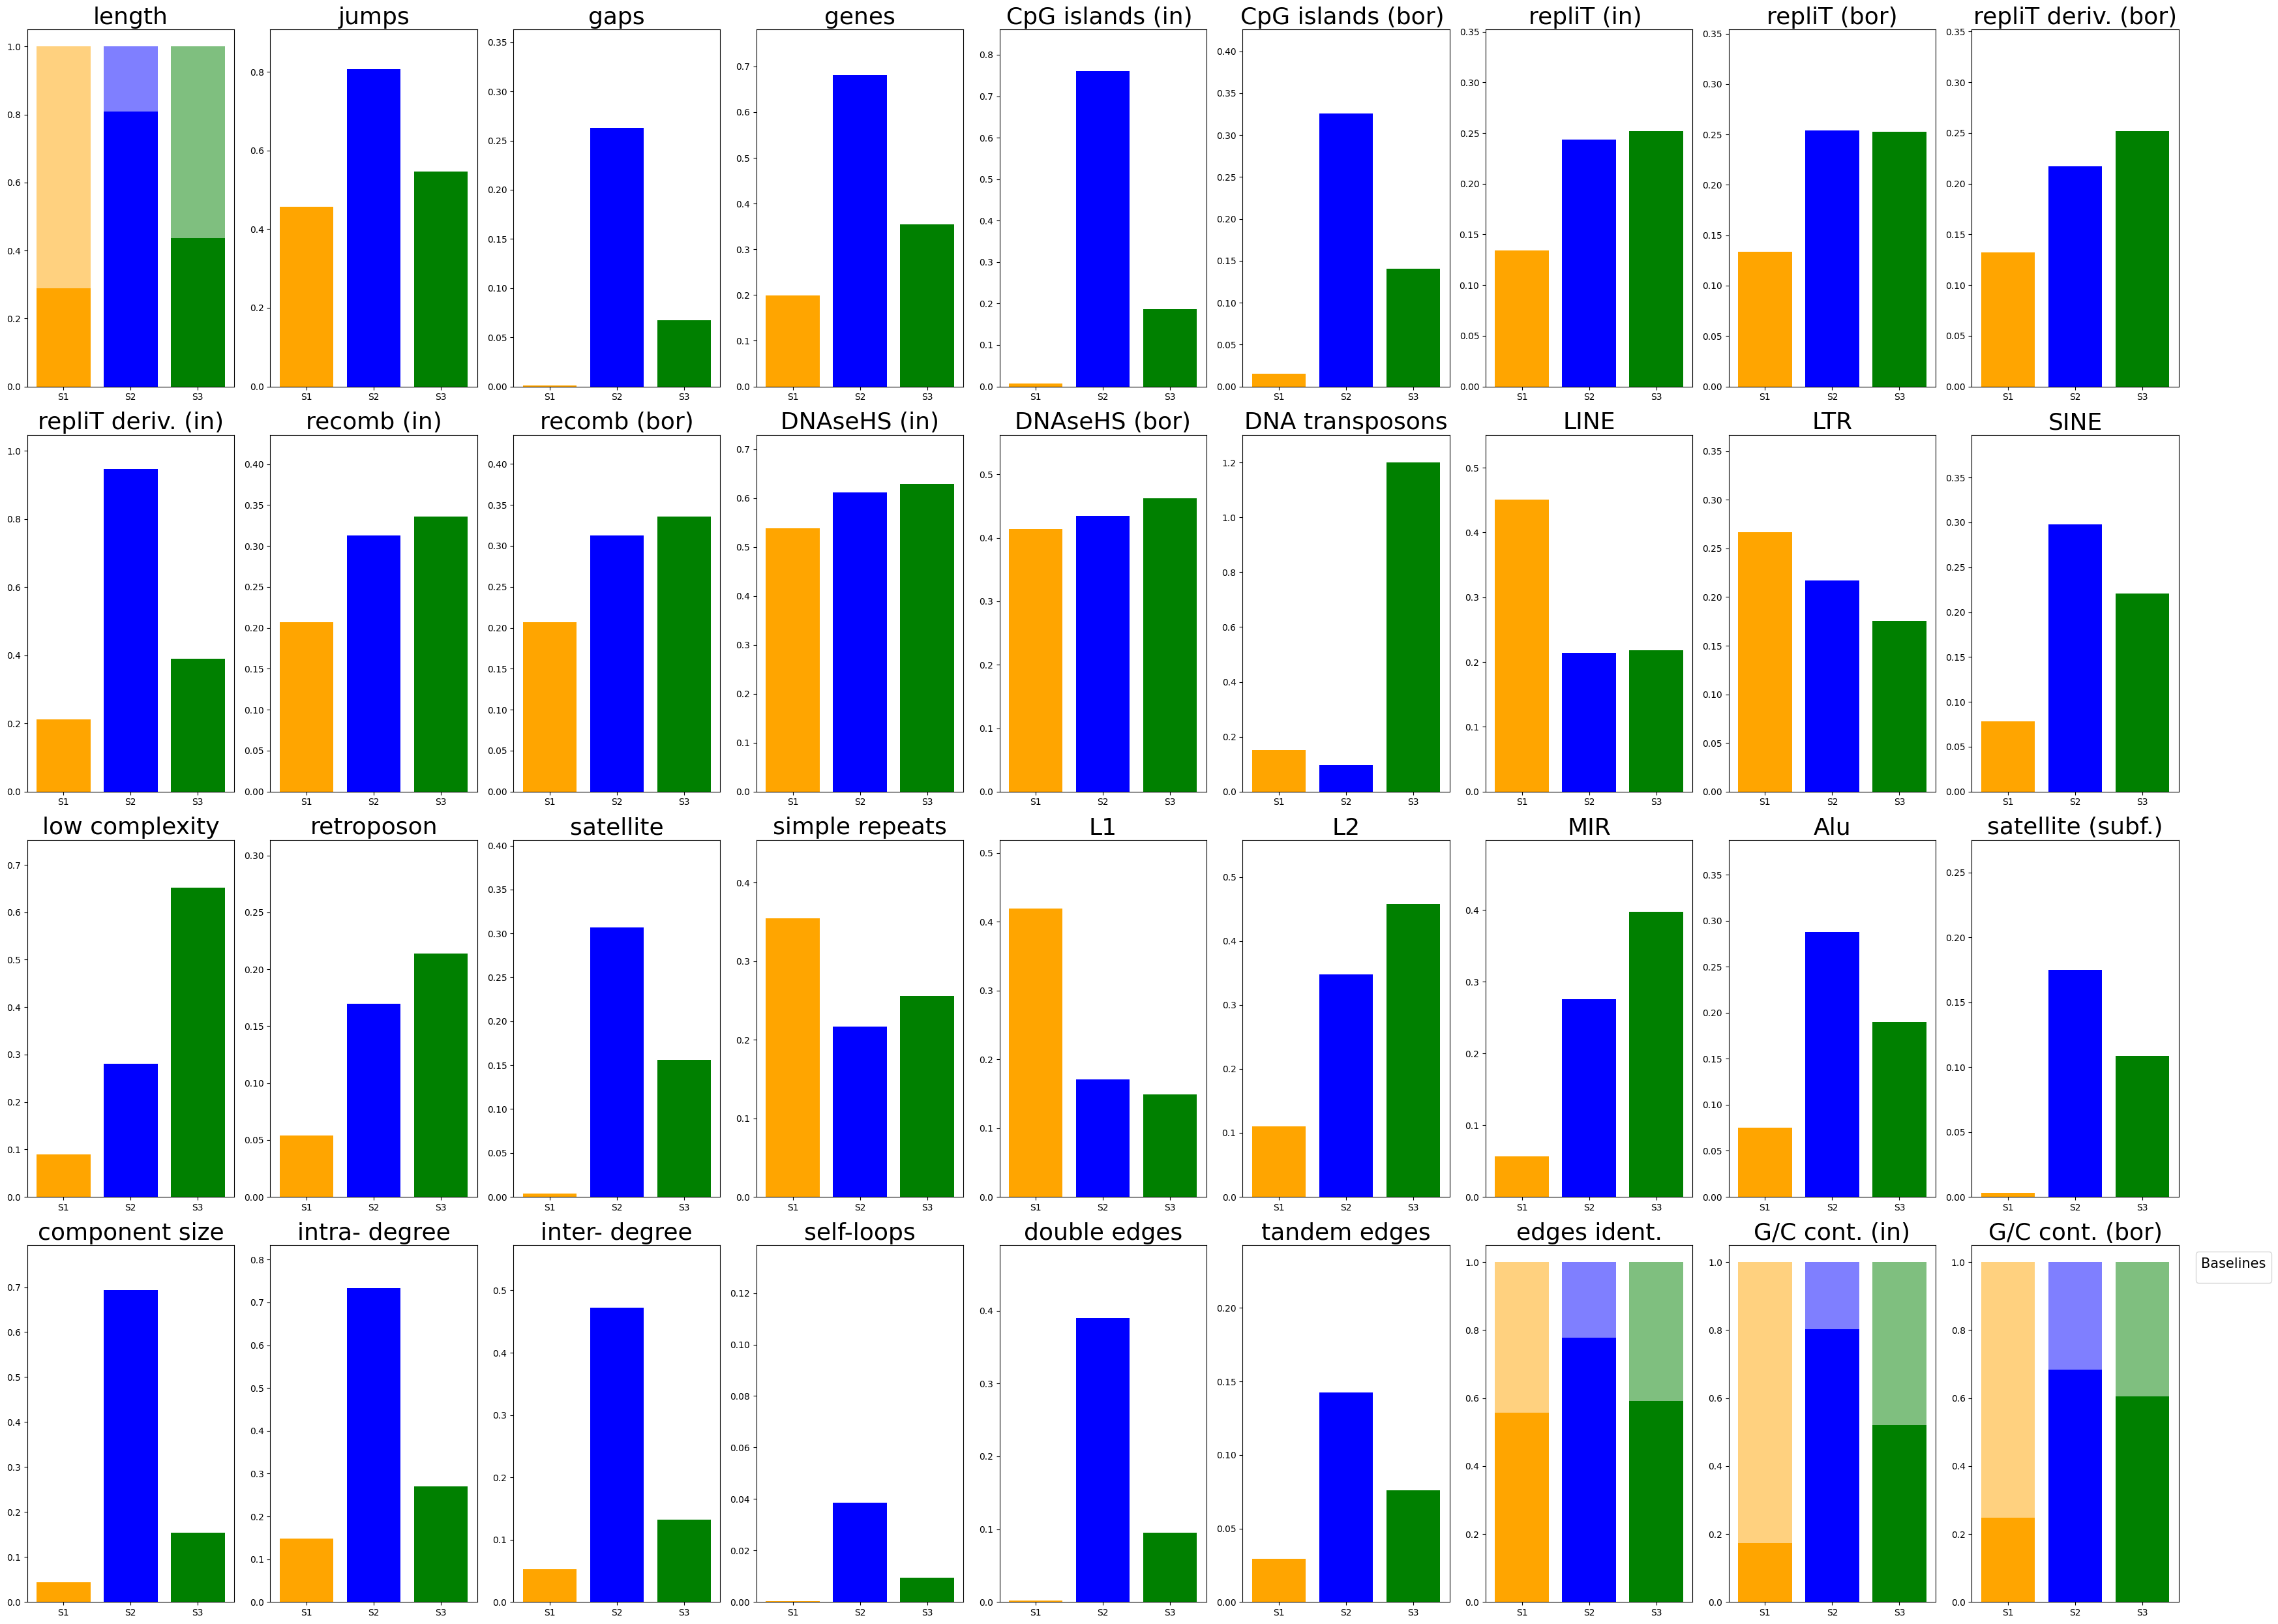

In [240]:

plt.subplots(4, 9, figsize=(35, 25))
l = 1
for i in range(40):
    if i in [0, 34, 36, 38]:
        ax = plt.subplot(4, 9, l)
        label = titles[i]
        plt.bar(["S1", "S2", "S3"], np.divide(normalized_H.transpose()[i], np.sum([normalized_H.transpose()[i], normalized_H.transpose()[i+1]], axis=0)), color=c,
                bottom=np.divide(normalized_H.transpose()[i+1], np.sum([normalized_H.transpose()[i], normalized_H.transpose()[i+1]], axis=0)), alpha=0.5)
        plt.bar(["S1", "S2", "S3"], np.divide(normalized_H.transpose()[i+1], np.sum([normalized_H.transpose()[i], normalized_H.transpose()[i+1]], axis=0)), color=c)
        
        short_patch = mpatches.Patch(hatch='O', label="Short " + label)
        long_patch = mpatches.Patch(hatch='*', label="Long " + label)
        
        plt.title(label, fontsize=26)
        l += 1
    elif i in [1, 35, 37, 39]:
        pass
    else:
        plt.subplot(4, 9, l)
        plt.bar(["S1", "S2", "S3"], normalized_H.transpose()[i], color=c)
        plt.title(titles[i], fontsize=26)
        plt.ylim(0.0, np.max(normalized_H.transpose()[i]) + 0.1) 
        
        # Add baseline values
        #plt.axhline(y=baseline[i], color='black', linestyle='--', linewidth=2)
        
        l += 1

# Add legend for baseline values
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=15, title="Baselines", title_fontsize=15)

plt.tight_layout()
plt.savefig("SD_network/NMF_Analysis/outputs/1MB/s=3.pdf", format="pdf")
plt.show()

Assign each duplicated region to one of the three signatures predicted by NMF.

In [212]:
def get_duplicated_regions():
    add_columns=["length",'component_size', 'intra_degree', 'iner_degree', 'self_loops', 'edges_double', 'edges_tandem','edges_ident_mean']
    
    old_data=pd.read_csv("SD_network/NMF_Analysis/files/Duplicated_Regions_old_data.csv")

    duplicated_regions=pd.read_csv("SD_network/NMF_Analysis/files/out_df_ws_jumps.csv")
    
    
    
    duplicated_regions["CG_frac_l"][duplicated_regions["CG_frac_l"]==-1.000]=0.0
    duplicated_regions["CG_frac_l"][duplicated_regions["CG_frac_l"]==0.0]=duplicated_regions["CG_frac_r"][duplicated_regions["CG_frac_l"]==0.0]   #np.mean(duplicated_regions["CG_frac_l"])
    
    duplicated_regions["CG_frac_r"][duplicated_regions["CG_frac_r"]==-1.000]=0.0
    duplicated_regions["CG_frac_r"][duplicated_regions["CG_frac_r"]==0.0]=duplicated_regions["CG_frac_l"][duplicated_regions["CG_frac_r"]==0.0] #np.mean(duplicated_regions["CG_frac_r"])
    
    duplicated_regions["CG_frac_in"][duplicated_regions["CG_frac_in"]==-1.000]=0.0
    duplicated_regions["CG_frac_in"][duplicated_regions["CG_frac_in"]==0.0]=np.mean(duplicated_regions["CG_frac_in"])
    duplicated_regions["CG_frac"]=(duplicated_regions["CG_frac_l"]+duplicated_regions["CG_frac_r"])/2
    
    duplicated_regions["CG_frac"][duplicated_regions["CG_frac"]==0.0]=np.mean(duplicated_regions["CG_frac_in"])
    
    duplicated_regions.drop(["CG_frac_l","CG_frac_r"],axis=1,inplace=True)
    
    for i in add_columns:
        duplicated_regions[i]=old_data[i]
    
    left_right_columns=["DNA","LINE","LTR","SINE","Low_complexity","Retroposon","Satellite","Simple_repeat","rRNA","snRNA","scRNA","srpRNA","tRNA","RC", 'L1_s', 'L2_s', 'MIR_s', 'Alu_s', 'Satellite_s']
    
    for i in left_right_columns:
        duplicated_regions[i]=duplicated_regions[i+"_r"]+duplicated_regions[i+"_l"]
        duplicated_regions.drop([i+"_r",i+"_l"],axis=1,inplace=True)
        
    return duplicated_regions

In [213]:
centro=pd.read_csv("SD_network/NMF_Analysis/files/out_df_ws_jumps.csv")["centro"]
telo=pd.read_csv("SD_network/NMF_Analysis/files/out_df_ws_jumps.csv")["telo"]

duplicated_regions=get_duplicated_regions()


/scratch/local/ipykernel_46050/4176514171.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  duplicated_regions["CG_frac_l"][duplicated_regions["CG_frac_l"]==-1.000]=0.0
/scratch/local/ipykernel_46050/4176514171.py:10: SettingWithCopyWarni

In [214]:
duplicated_regions

,chr,coor_s,coor_e,ids,length,centro,telo,gaps,genes,intra_frac,...,snRNA,scRNA,srpRNA,tRNA,RC,L1_s,L2_s,MIR_s,Alu_s,Satellite_s
0,1,10000,207666,id1,197666,121818793,0,2,6,0.206,...,0,0,0,0,0,0,0,0,0,0
1,1,257666,297956,id2,40290,121728503,247666,2,0,0.208,...,0,0,0,0,0,0,0,0,1,0
2,1,347968,535988,id3,188020,121490471,337968,2,1,0.229,...,0,0,0,0,0,0,0,0,0,0
3,1,585988,817292,id4,231304,121209167,575988,1,2,0.255,...,0,0,0,0,0,0,0,0,0,0
4,1,817367,821400,id5,4033,121205059,807367,0,1,0.000,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6651,22,48911634,48912886,id4359,1252,33857316,1895582,0,0,1.000,...,0,0,0,0,0,0,0,0,0,0
6652,22,49383944,49385910,id4360,1966,34329626,1422558,0,0,1.000,...,0,0,0,0,0,1,0,0,0,0
6653,22,49386637,49388496,id4361,1859,34332319,1419972,0,0,1.000,...,0,0,0,0,0,1,0,0,0,0
6654,22,50432257,50442552,id4362,10295,35377939,365916,0,1,1.000,...,0,0,0,0,0,0,0,0,1,0


In [215]:
def bin_column(df,col_name,binning_function):
    
    bin1=[]
    bin2=[]
    for i in df[col_name]:
        if binning_function(i)==0:
            bin1.append(1)
            bin2.append(0)
        else:
            bin1.append(0)
            bin2.append(1)
    df[col_name+"_0"]=bin1
    df[col_name+"_1"]=bin2
    df.drop(col_name,inplace=True,axis=1)

In [216]:
def binning(x):
    if x>0.933:
        return 1
    else:
        return 0

def binning1(x): 
    if x>0.40174999999999994:
        return 1
    else:
        return 0
    
def binning2(x): 
    if x>0.424:
        return 1
    else:
        return 0
    
def binning_length(x):
    if x<2574.5:
        return 0 
    else:
        return 1    

In [217]:
bin_column(duplicated_regions,"length",binning_length)
bin_column(duplicated_regions,"edges_ident_mean",binning)
bin_column(duplicated_regions,"CG_frac",binning1)
bin_column(duplicated_regions,"CG_frac_in",binning2)

drop_cols=[]
for i in duplicated_regions.columns:
    if i not in data_nonzero.columns:
        drop_cols.append(i)

duplicated_regions.drop(drop_cols,axis=1,inplace=True)
duplicated_regions=duplicated_regions[data_nonzero.columns]


Based on distance from pericentromeric/telomeric a SD is assigned close to one of them or else classified as other

In [218]:
colors=[]
colors_index=[]
color_labels=[]
for i in range(len(centro)):
    if telo[i]<5*(10**6):
        colors.append("blue")
        colors_index.append(1)
        color_labels.append("Subtelomere")
    elif centro[i]<5*(10**6):
        colors.append("red")
        colors_index.append(2)
        color_labels.append("Pericentromere")
    else:
        colors.append("grey")
        colors_index.append(0)
        color_labels.append("Other SD's")

In [219]:
scaler

MaxAbsScaler()

In [220]:
y=scaler.transform(duplicated_regions)

Assign each segmental duplication

In [221]:
from sklearn.linear_model import LinearRegression
classes=[]
probabilities=[]
error=[]
pvalues=[]
x=normalized_H
# x[0]=x_1
# x[2]=x_2

x=x.transpose()
for i in range(6656):
    y_cur=y[i]
    #print(y)
    est = LinearRegression(fit_intercept=False,positive=True)    
    reg= est.fit(x,y_cur)
    probabilities.append(np.array(reg.coef_))
    classes.append(np.argmax(np.array(reg.coef_)))
    #pvalues.append(reg.f_pvalue)

In [280]:
classes = np.array(classes)

np.count_nonzero(classes==0),np.count_nonzero(classes==1),np.count_nonzero(classes==2)

(4145, 1625, 886)

In [222]:
probabilities[0]

array([0.        , 0.04113766, 0.06314691])

In [223]:
data_copy = pd.read_csv("SD_network/NMF_Analysis/files/Duplicated_Regions_6.6k.csv")


In [224]:
data_copy.columns

Index(['chr', 'coor_s', 'coor_e', 'ids', 'length', 'centro', 'telo', 'gaps',
       'genes', 'intra_frac', 'cpgisl_in', 'cpgisl_bor', 'ctcf', 'repli_in',
       'repli_bor', 'repli_bor_deriv', 'repli_deriv', 'repli_vari',
       'recomb_in', 'recomb_bor', 'dnase_in', 'dnase_bor', 'used_coor_l_s',
       'used_coor_l_e', 'used_coor_r_s', 'used_coor_r_e', 'CG_frac_in',
       'jumps', 'CG_frac', 'component_size', 'intra_degree', 'iner_degree',
       'self_loops', 'edges_double', 'edges_tandem', 'edges_ident_mean', 'DNA',
       'LINE', 'LTR', 'SINE', 'Low_complexity', 'Retroposon', 'Satellite',
       'Simple_repeat', 'rRNA', 'snRNA', 'scRNA', 'srpRNA', 'tRNA', 'RC',
       'L1_s', 'L2_s', 'MIR_s', 'Alu_s', 'Satellite_s'],
      dtype='object')

In [ ]:
data_norm=preprocessing.MaxAbsScaler().fit_transform(data_copy[['jumps', 'length', 'gaps', 'genes', 'cpgisl_in',
       'cpgisl_bor', 'repli_in', 'repli_bor', 'repli_bor_deriv', 'repli_deriv',
       'recomb_in', 'recomb_bor', 'dnase_in', 'dnase_bor',
       'CG_frac_in', 'CG_frac', 'component_size', 'intra_degree',
       'iner_degree', 'self_loops', 'edges_double', 'edges_tandem',
       'edges_ident_mean', 'DNA', 'LINE', 'LTR', 'SINE', 'Low_complexity',
       'Retroposon', 'Satellite', 'Simple_repeat', 'L1_s', 'L2_s', 'MIR_s',
       'Alu_s', 'Satellite_s']])

In [226]:
reducer = umap.UMAP(min_dist=1.0,  n_neighbors=100)
embedding = reducer.fit_transform(data_norm)
embedding.shape

(6656, 2)

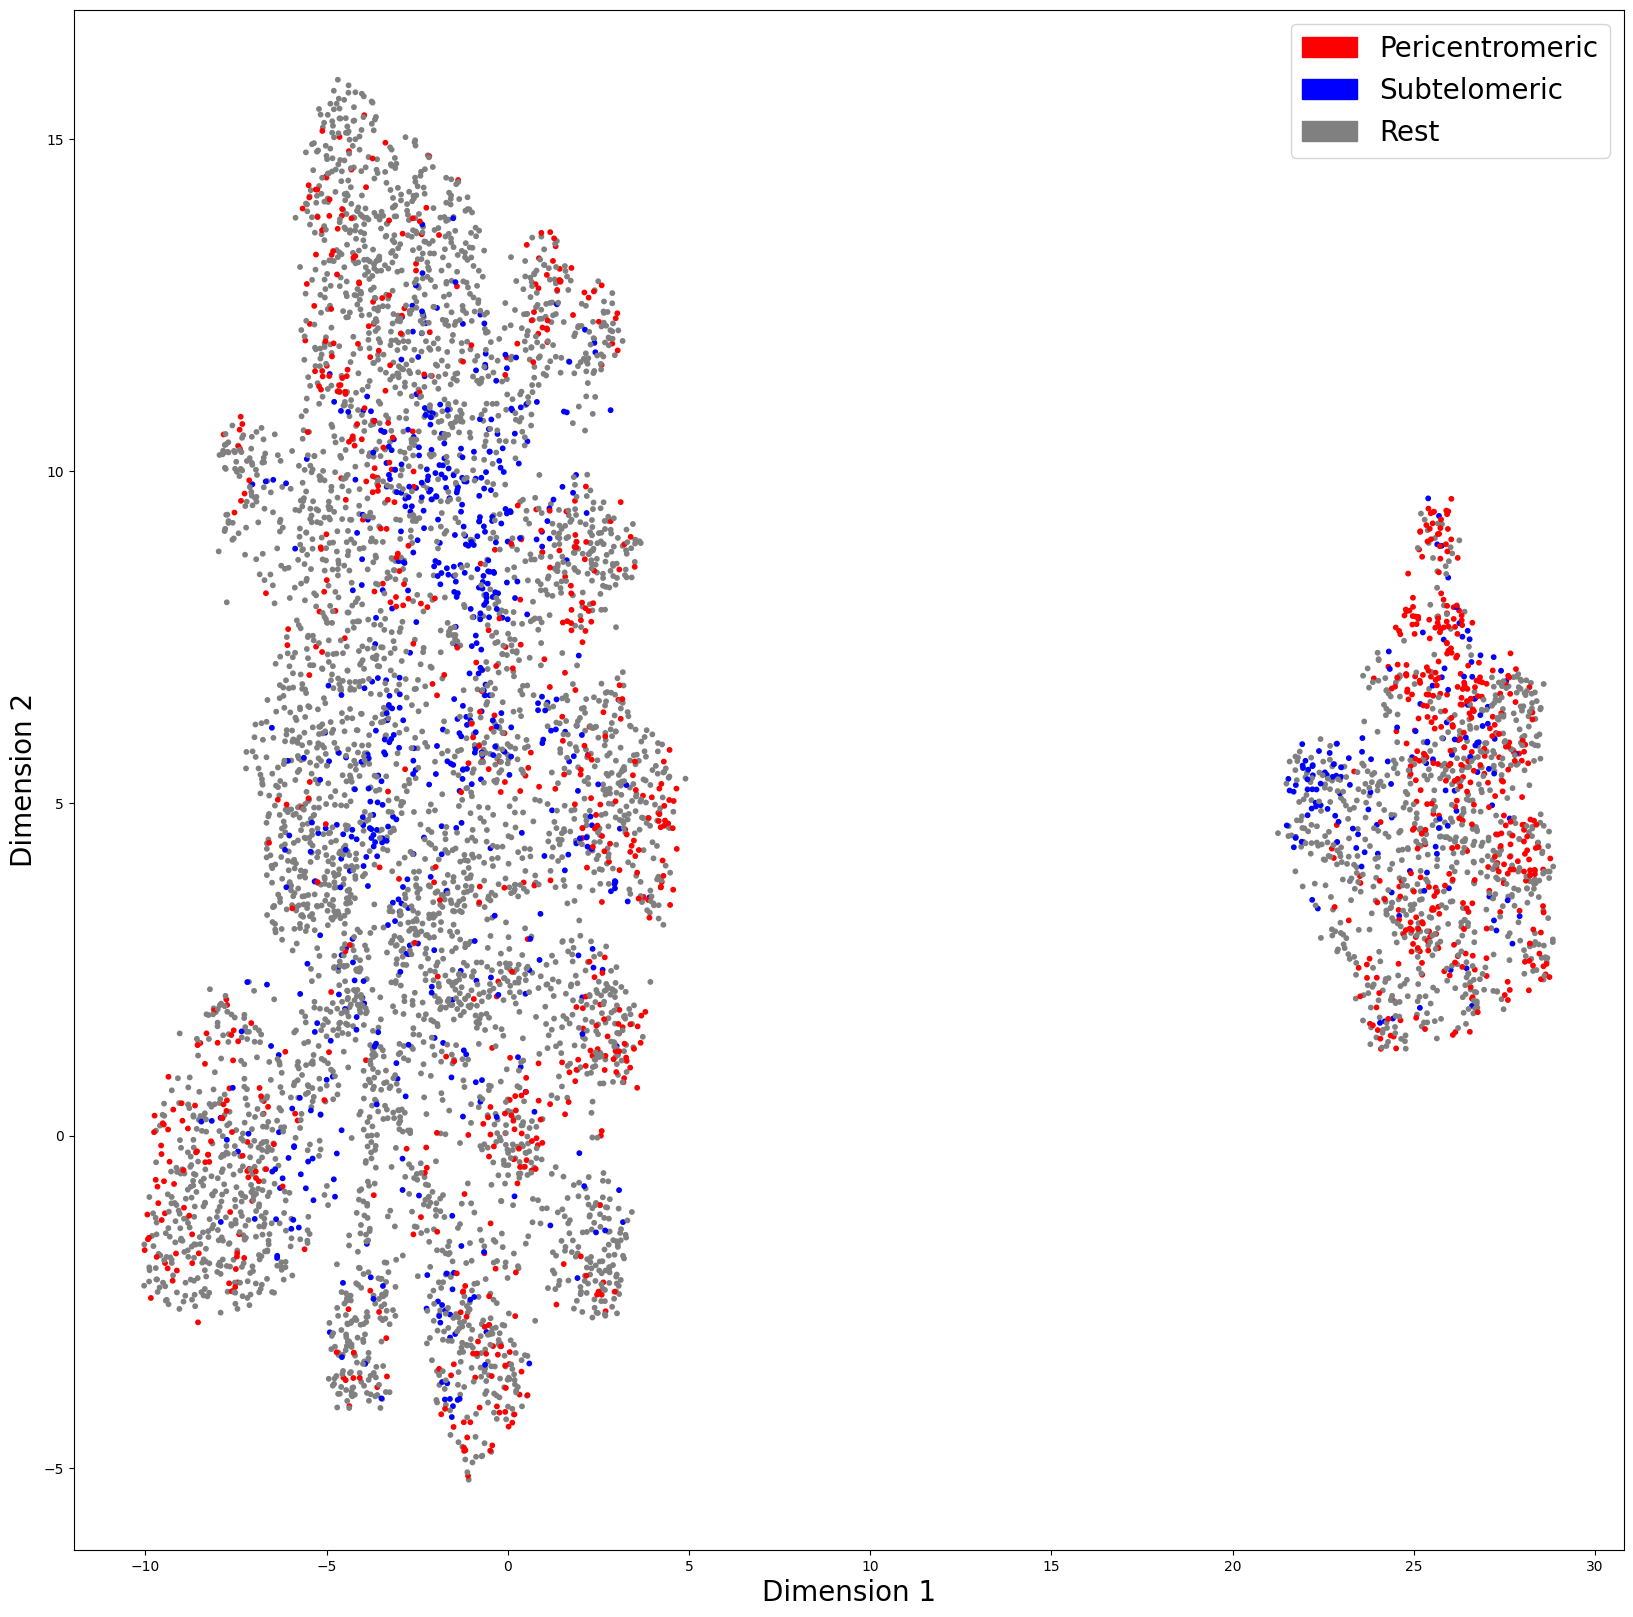

In [282]:
fig, ax = plt.subplots(figsize=(20,20))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],s=10,c=colors
);

red_patch = mpatches.Patch(color='red', label='Pericentromeric')
blue_patch = mpatches.Patch(color='blue', label='Subtelomeric')
grey_patch = mpatches.Patch(color='grey', label='Rest')

plt.xlabel("Dimension 1",fontsize=20)
plt.ylabel("Dimension 2",fontsize=20)


ax.legend(handles=[red_patch,blue_patch,grey_patch],fontsize=20)

plt.savefig("SD_network/NMF_Analysis/outputs/1MB/telo_centro.pdf",format="pdf")


plt.show()
plt.close()

In [228]:
# pca 
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_norm)

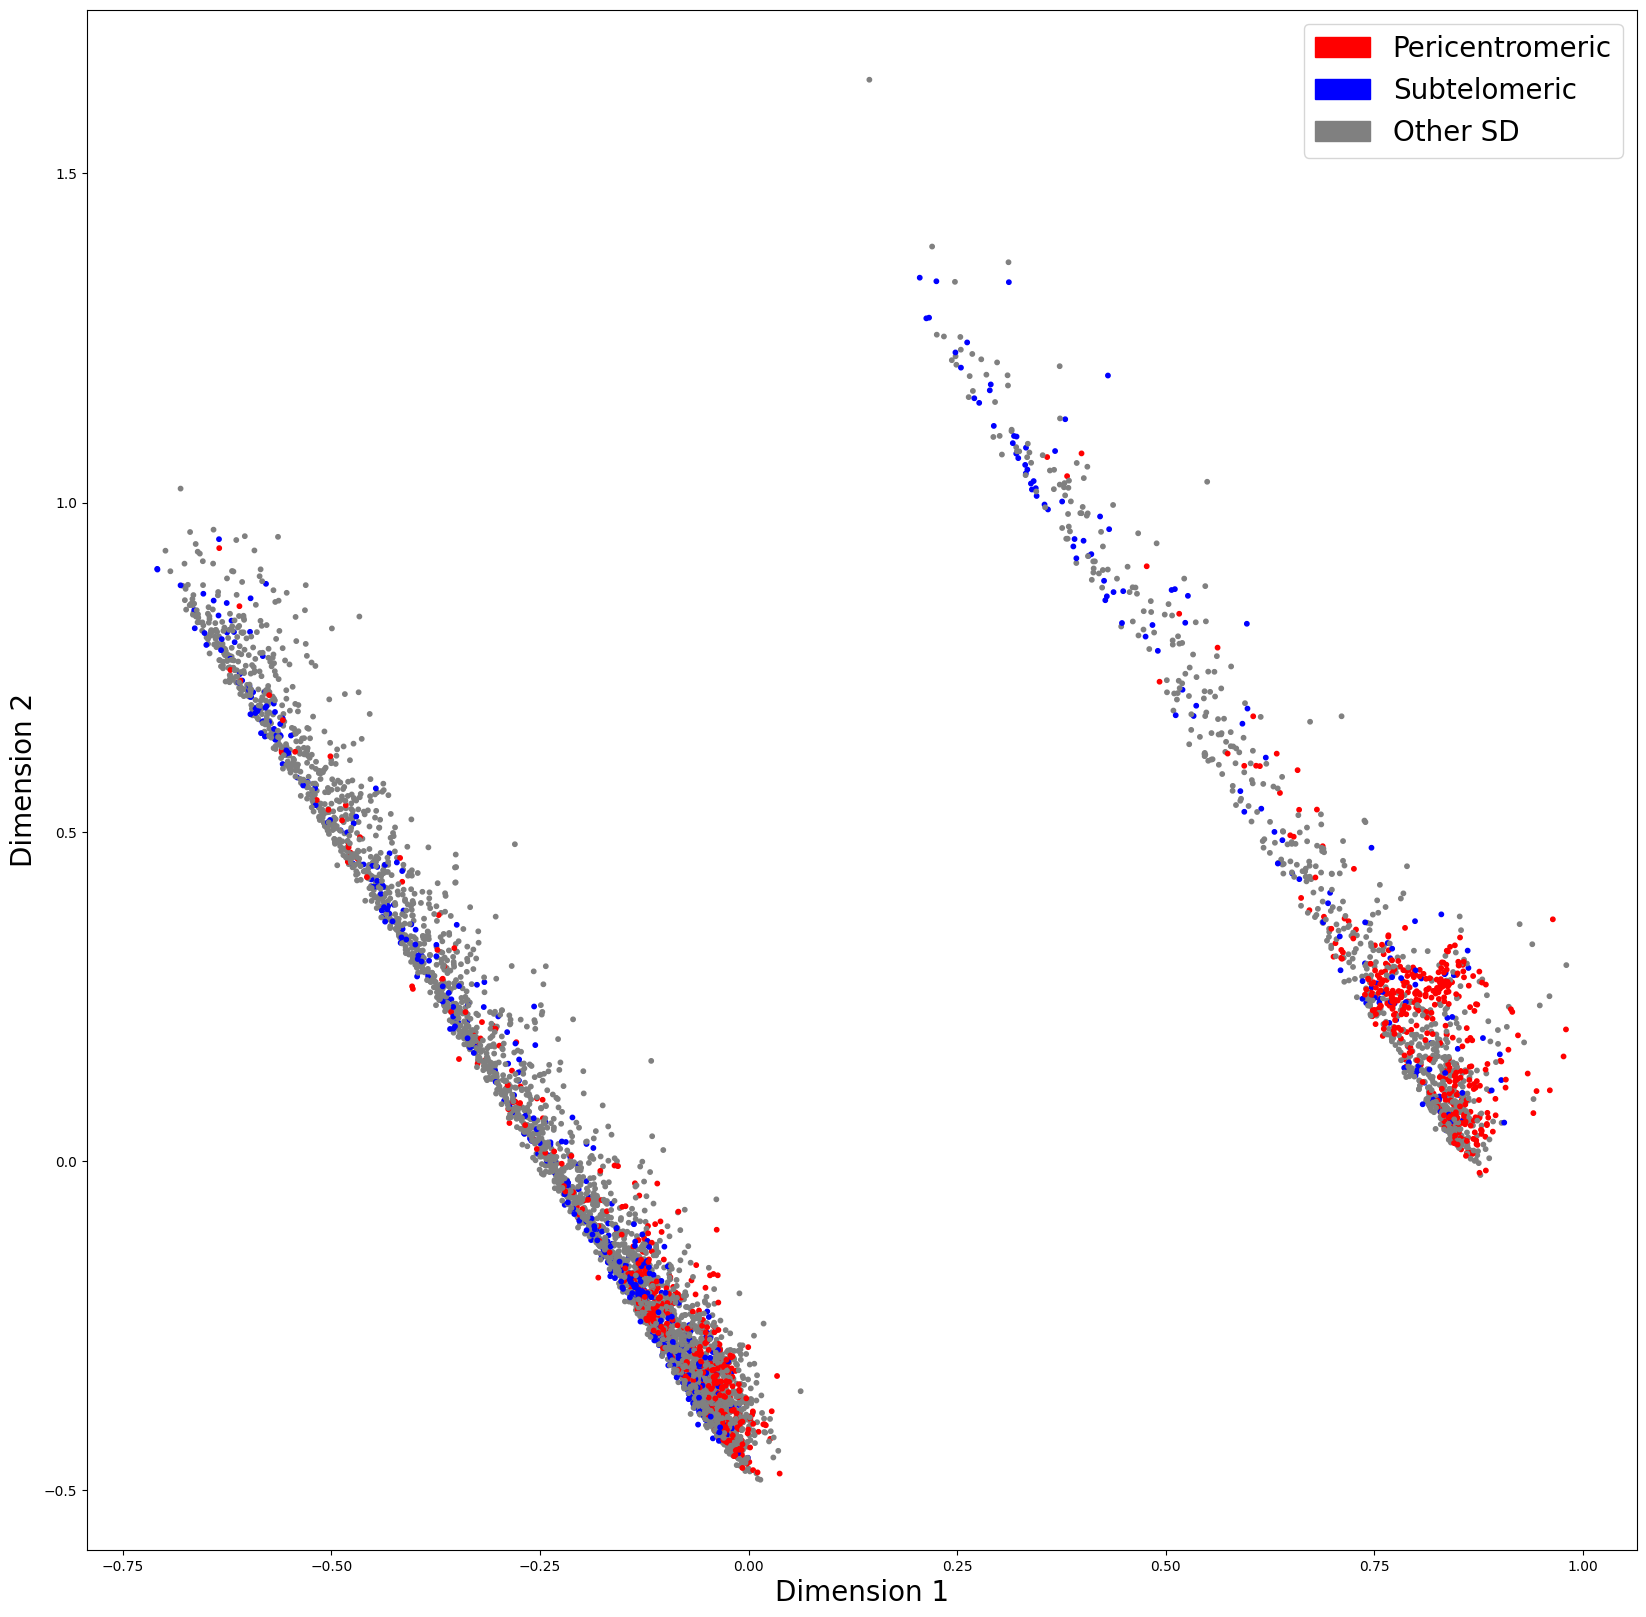

In [229]:
fig, ax = plt.subplots(figsize=(20,20))

plt.scatter(
    pca_result[:, 0],
    pca_result[:, 1],s=10,c=colors
);

red_patch = mpatches.Patch(color='red', label='Pericentromeric')
blue_patch = mpatches.Patch(color='blue', label='Subtelomeric')
grey_patch = mpatches.Patch(color='grey', label='Other SD')

plt.xlabel("Dimension 1",fontsize=20)
plt.ylabel("Dimension 2",fontsize=20)


ax.legend(handles=[red_patch,blue_patch,grey_patch],fontsize=20)

plt.savefig("SD_network/NMF_Analysis/outputs/1MB/telo_centro_pca.pdf",format="pdf")


plt.show()
plt.close()

For each signature, how much does it contribute to different regions.

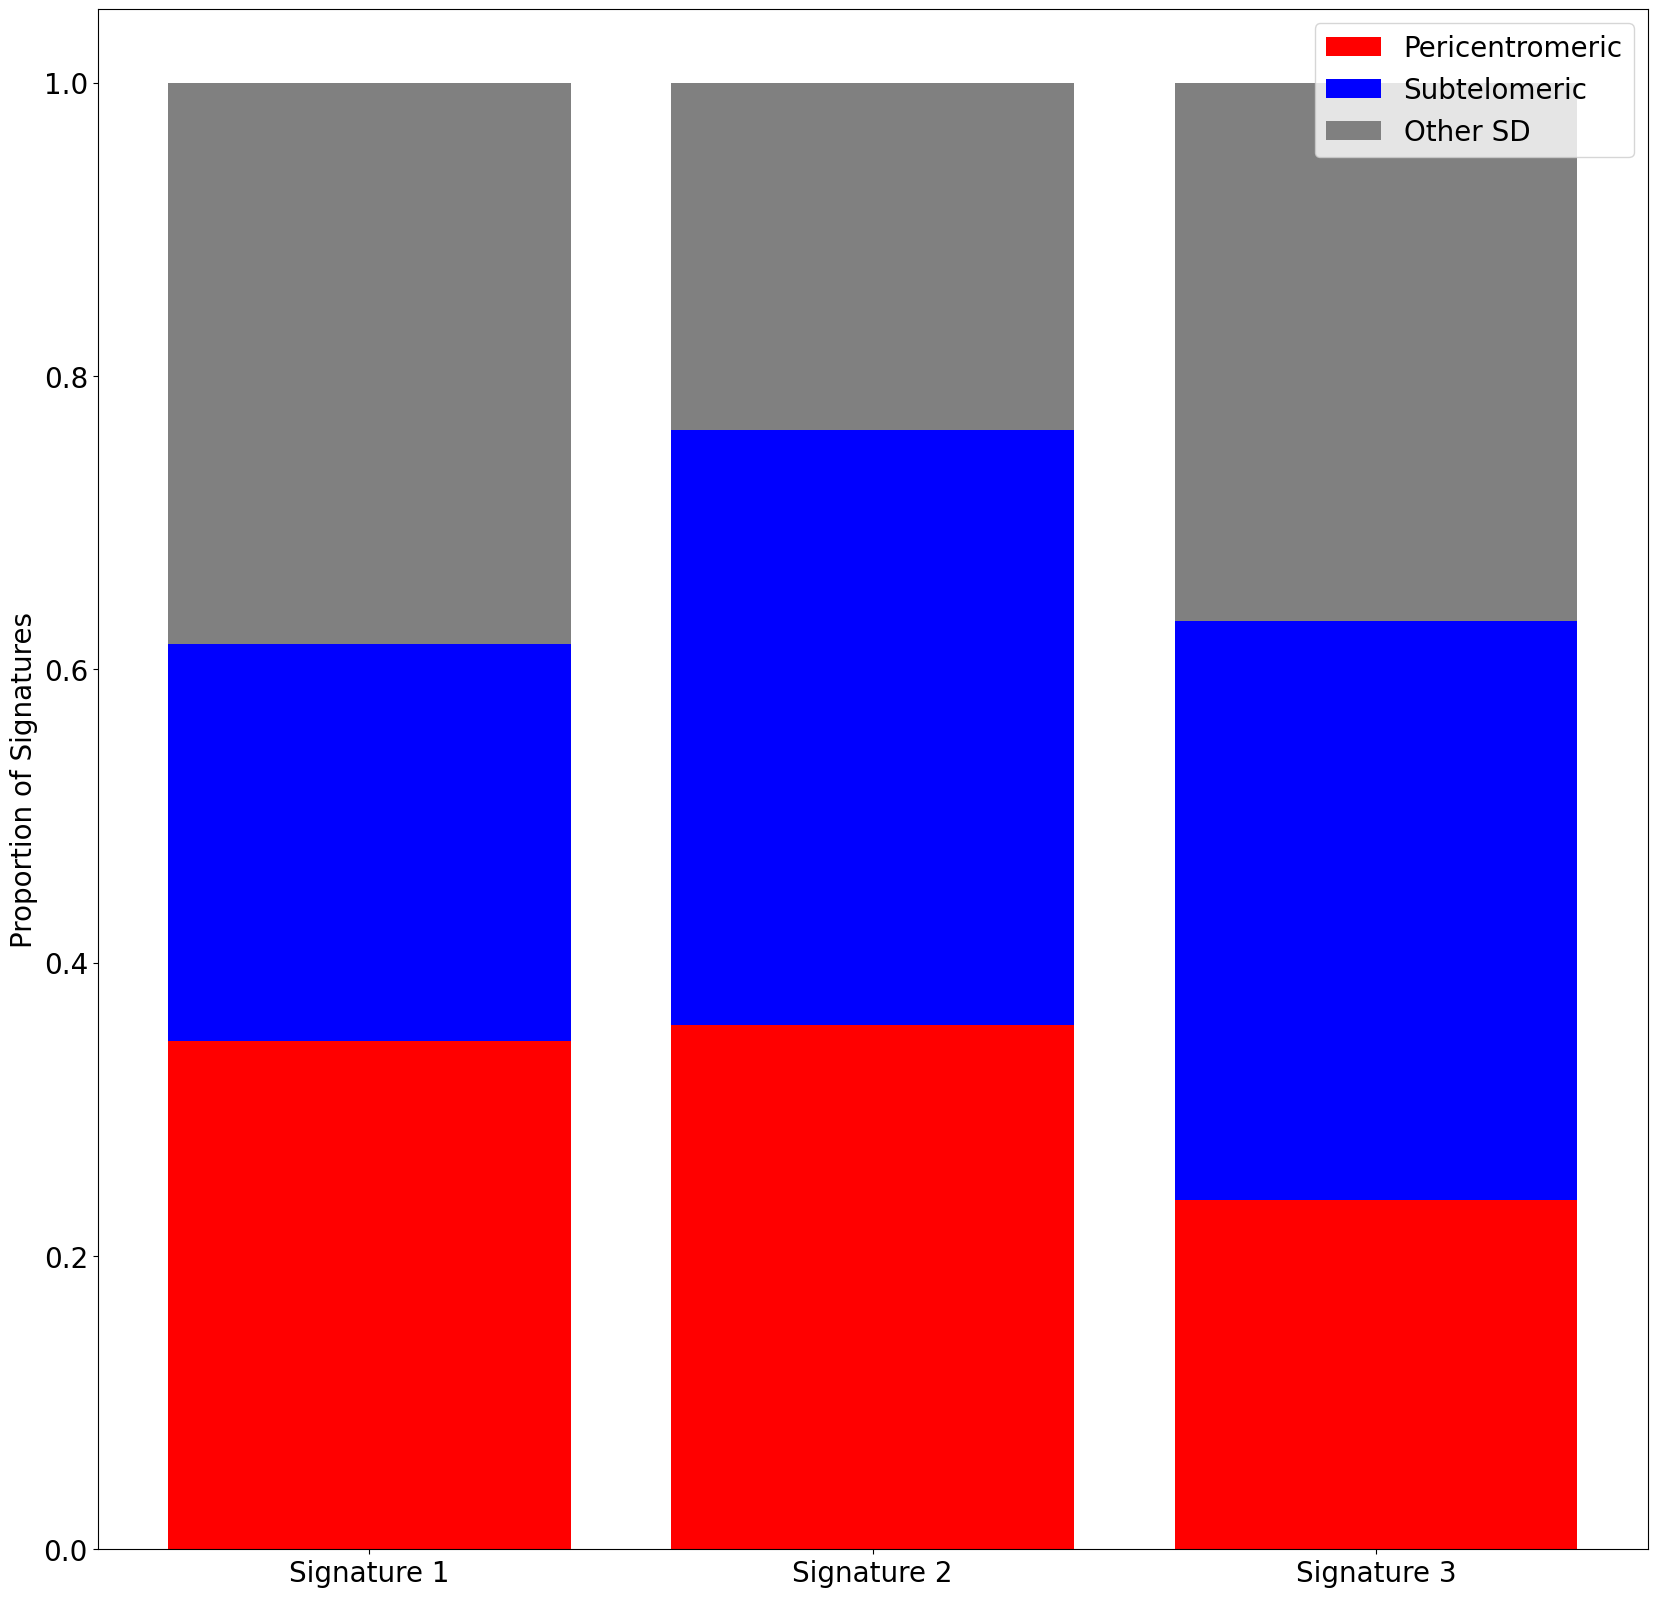

In [283]:
plt.figure(figsize=(20,20))
regions = ["Pericentromeric" , "Subtelomeric", "Rest"]
colors = np.array(colors)
probabilities = np.array(probabilities)

for i in range(3):
    values = [0, 0, 0]
    j = 0
    for c in ["red", "blue", "grey"]:
         value = np.mean(np.divide(probabilities, np.sum(probabilities,axis=1)[:, np.newaxis])[:,i][colors == c])
         values[j] = value
         j+=1
    j=0
    bottom = 0
    for c in ["red", "blue", "grey"]:
        plt.bar("Signature "+str(i+1), (values/np.sum(values))[j], color=c, bottom=bottom)
        bottom += (values/np.sum(values))[j]
        j+=1
plt.legend(["Pericentromeric", "Subtelomeric", "Other SD"], fontsize=20)
plt.ylabel("Proportion of Signatures", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("SD_network/NMF_Analysis/outputs/1MB/signature_proportions.pdf", format="pdf")
plt.show()

Bar plot of the classes, what % of each class is in each signature based on probabilities

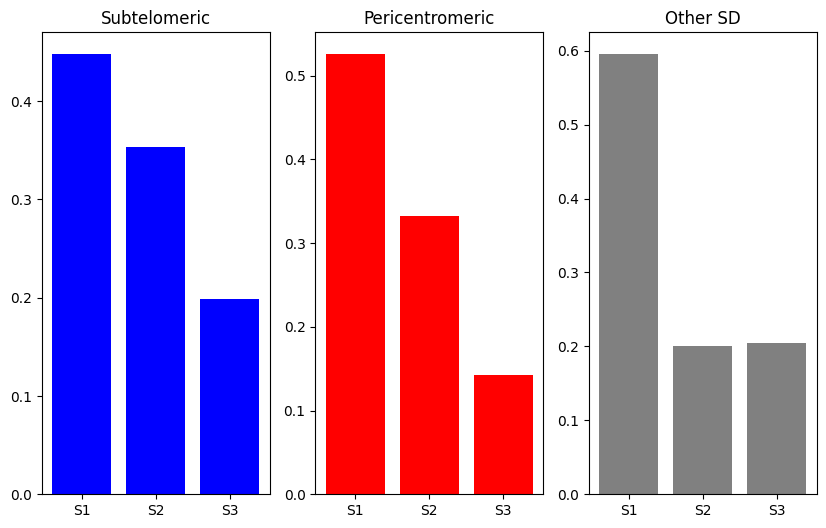

In [230]:
regions = ["Subtelomeric", "Pericentromeric", "Other SD"]
colors = np.array(colors)
probabilities = np.array(probabilities)
plt.figure(figsize=(10, 6))
i=1
for c in ['blue', 'red', 'grey']:
    plt.subplot(1, 3, i)
    m = np.mean(probabilities[colors == c], axis=0)
    plt.bar(np.arange(3), m/np.sum(m), color=c)
    plt.xticks(np.arange(3), ['S1', 'S2', 'S3'])
    plt.title(regions[i-1])
    i+=1
plt.show()

WHAT PERCENTAGE OF EACH SEGMENT IS CONTRIBUTED BY THE THREE SIGNATURES


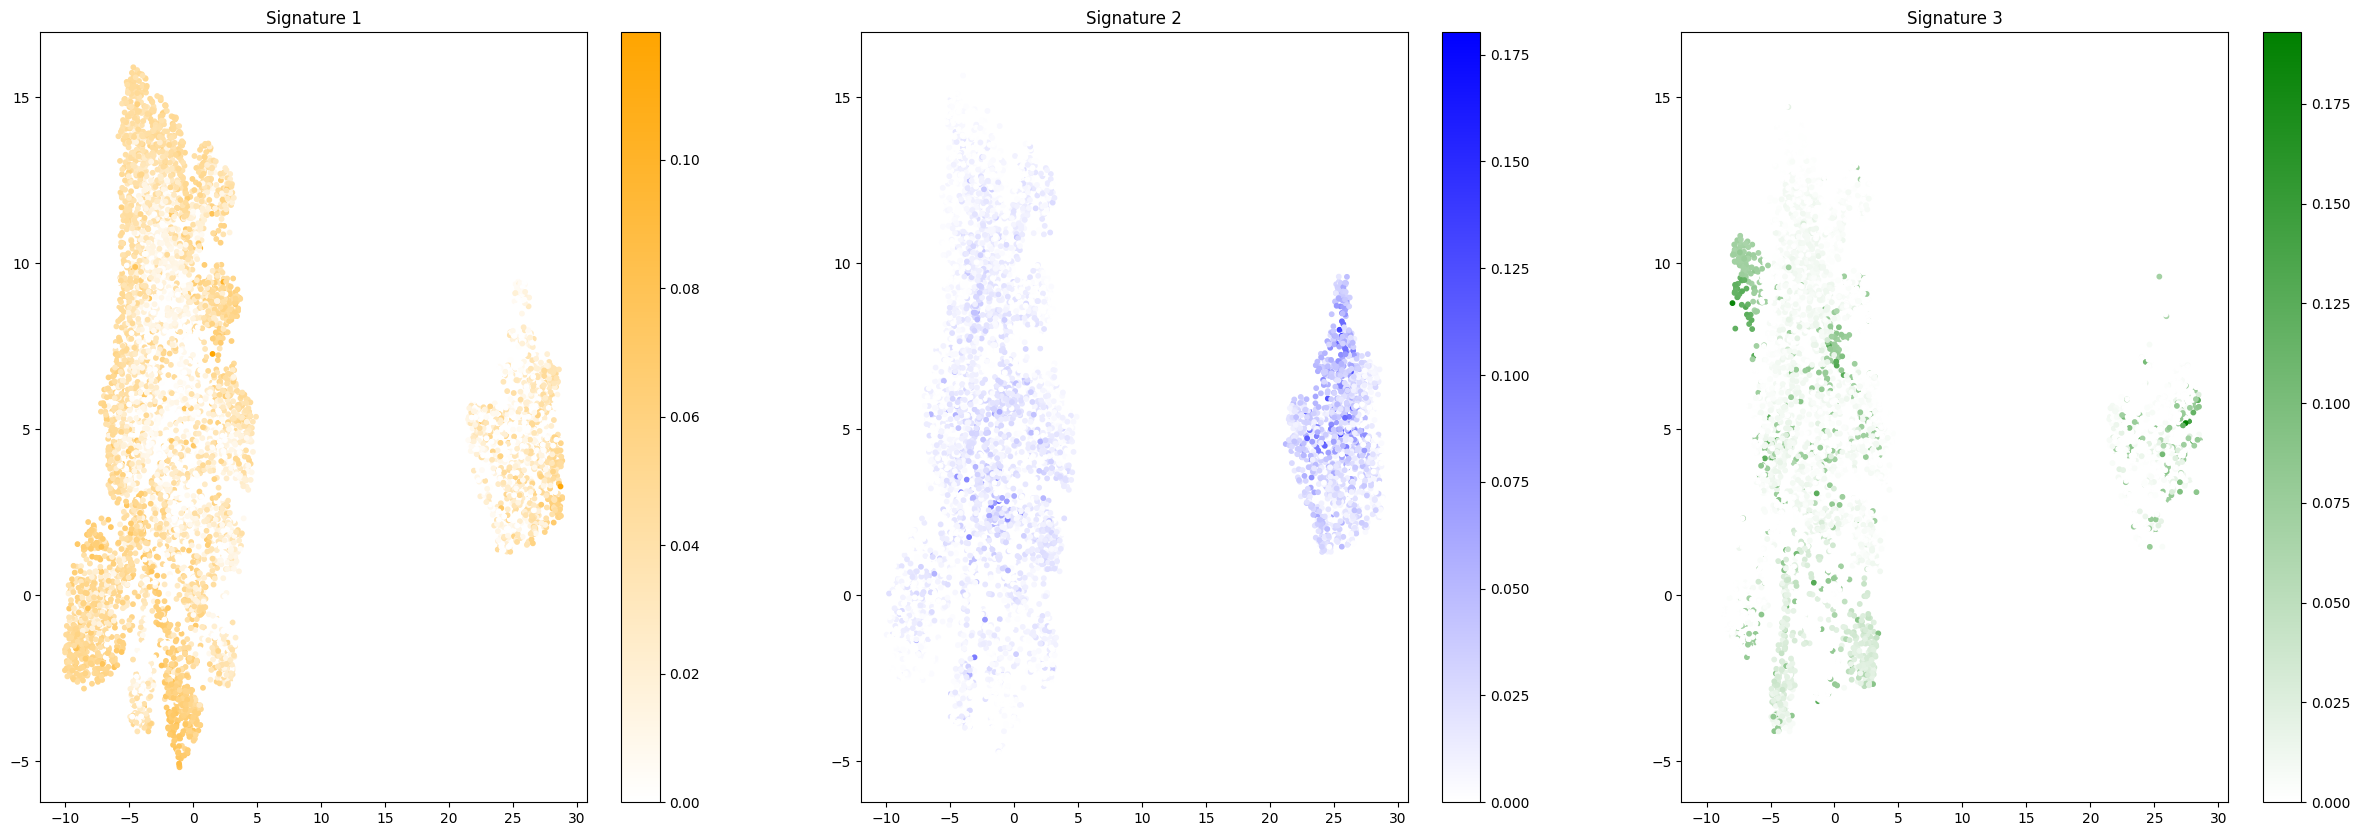

In [231]:
plt.figure(figsize=(30, 10))
c=["orange","blue","green"]
for i in range(3):
    plt.subplot(1, 3, i+1)
    cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', ['white', c[i]])
    plt.scatter(embedding[:,0],embedding[:,1],c=probabilities[:,i],cmap=cmap,s=10)
    plt.colorbar()
    plt.title(f"Signature {i+1}")
plt.show()

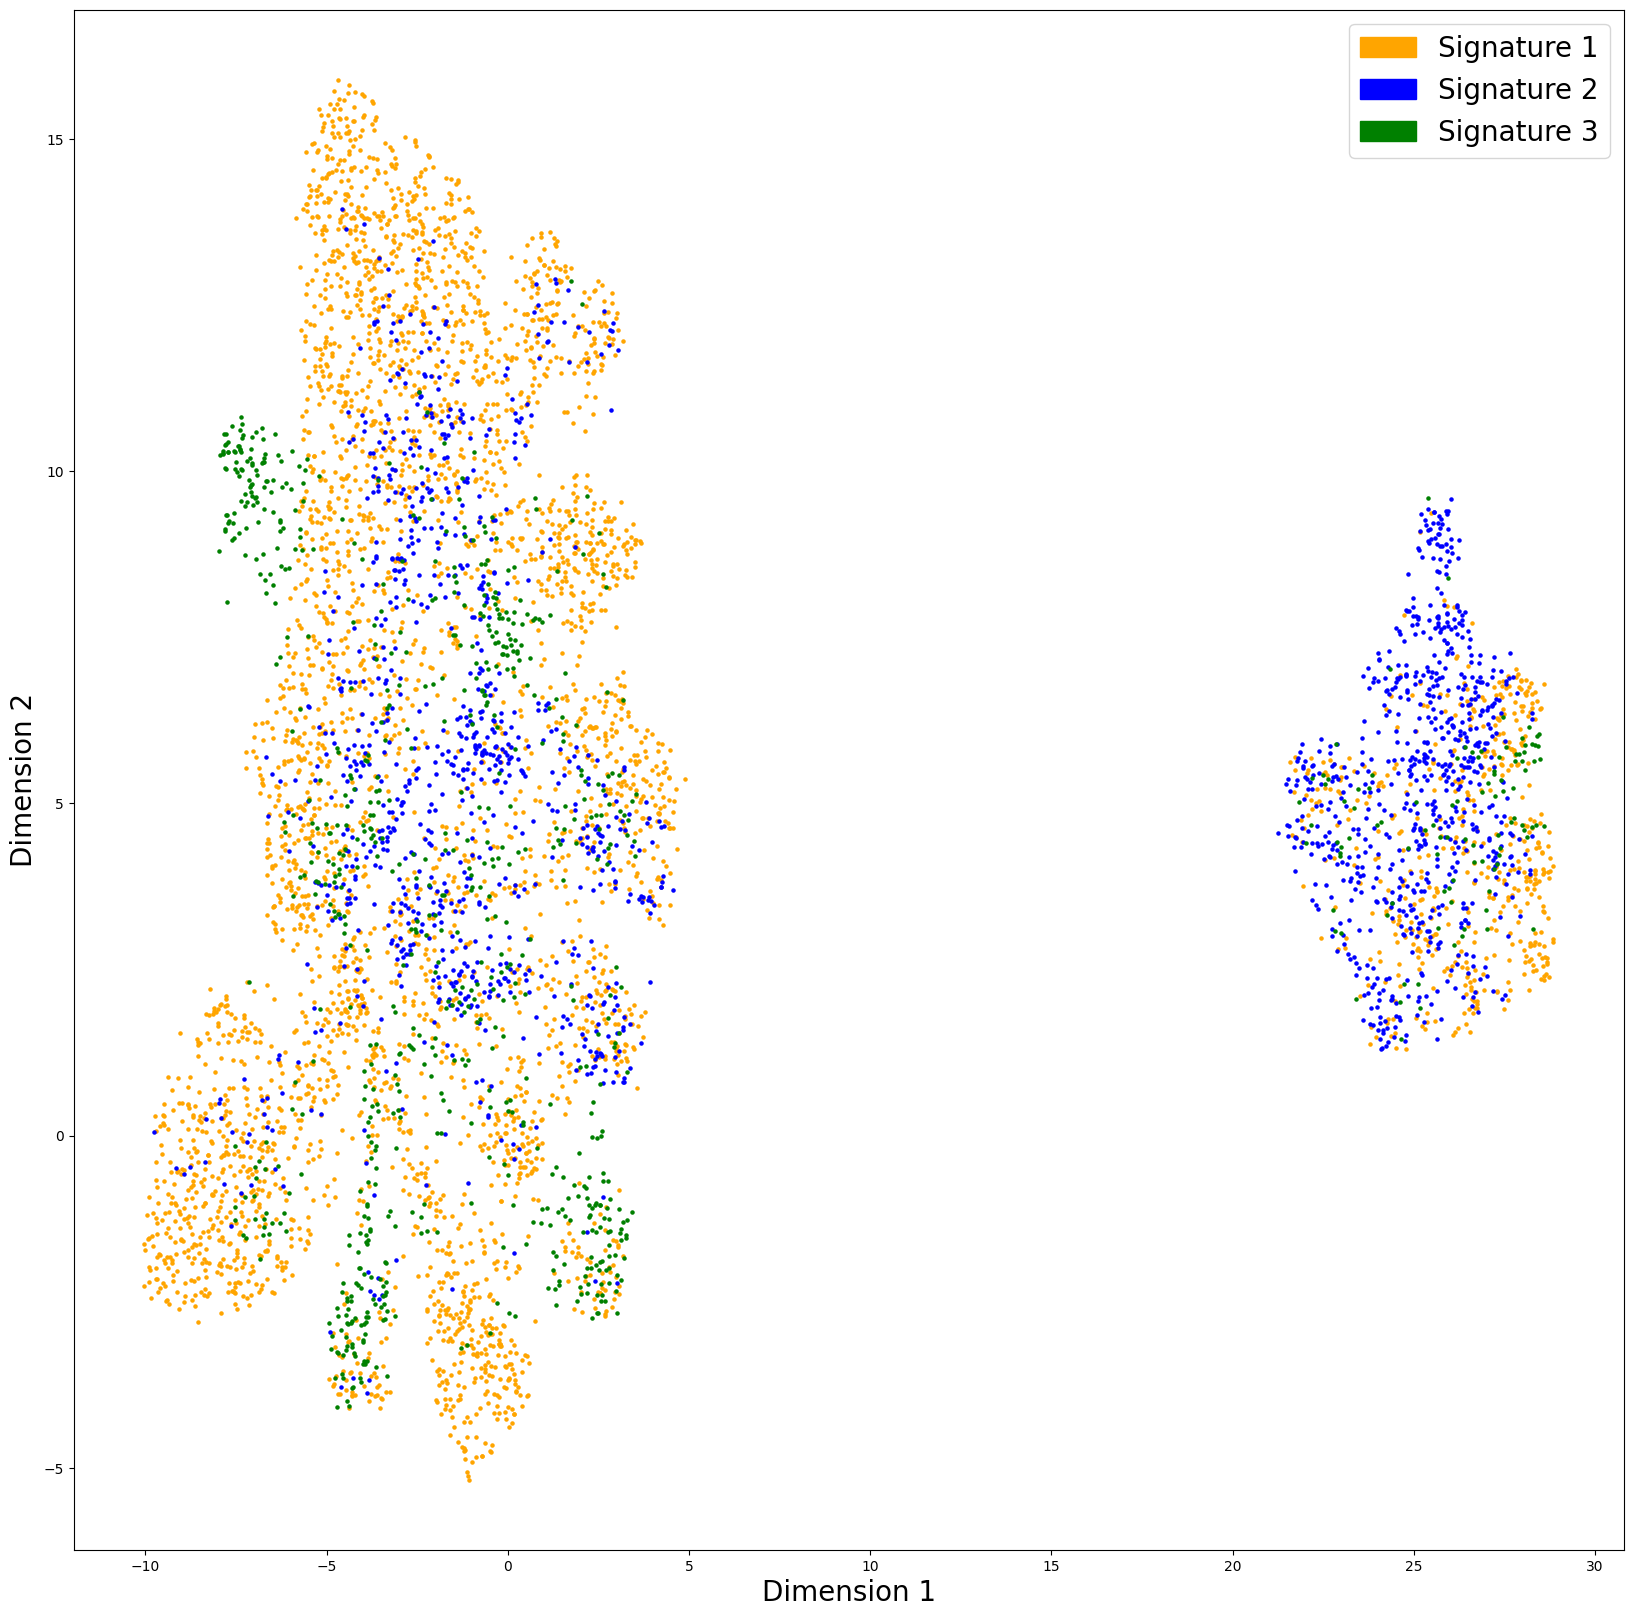

In [232]:
fig,ax=plt.subplots(figsize=(20,20))
c=["orange","blue","green"]

for i in range(3):
    plt.scatter(
            embedding[:, 0][np.array(classes)==i],
            embedding[:, 1][np.array(classes)==i],
            s=5,color=c[i]
        )
    
red_patch = mpatches.Patch(color='orange', label='Signature 1')
blue_patch = mpatches.Patch(color='blue', label='Signature 2')
grey_patch = mpatches.Patch(color='green', label='Signature 3')

plt.xlabel("Dimension 1",fontsize=20)
plt.ylabel("Dimension 2",fontsize=20)


ax.legend(handles=[red_patch,blue_patch,grey_patch],fontsize=20)
plt.savefig("SD_network/NMF_Analysis/outputs/1MB/sig_assignment.pdf",format="pdf")

plt.show()
plt.close()

In [233]:
sig=[[],[],[]]
centro=np.sort(np.array(centro))
for i in range(len(centro)):
    if centro[i]<10**7:
        sig[classes[i]].append(centro[i])

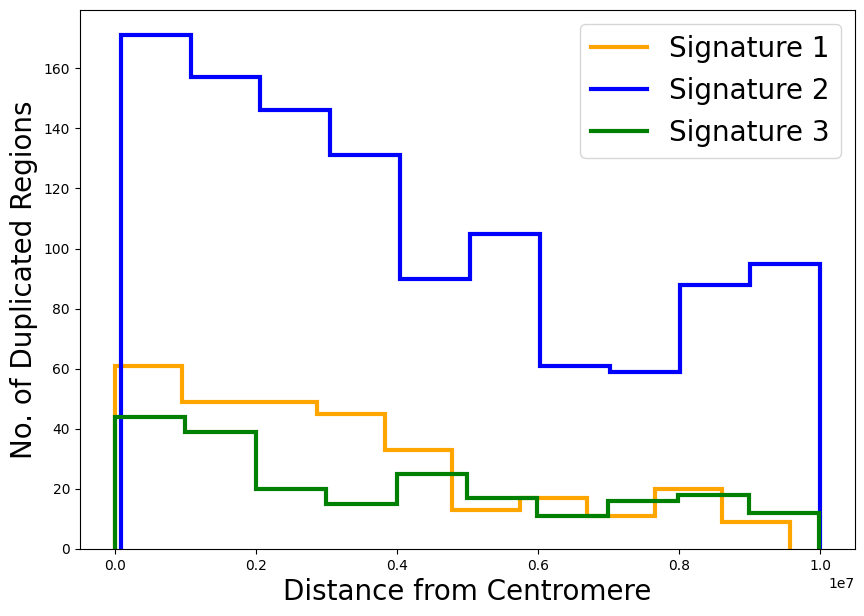

In [234]:
N=11

ind = np.arange(1,N)  
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
plt.hist(sig[1], density=False, histtype='step', stacked=True ,label="Signature 1",color="orange" ,linewidth=3)
plt.hist(sig[0], density=False, histtype='step', stacked=True,label="Signature 2",color="blue",linewidth=3)
plt.hist(sig[2], density=False, histtype='step', stacked=True,label="Signature 3",color="green",linewidth=3)

plt.xlabel("Distance from Centromere",fontsize=20)
plt.ylabel("No. of Duplicated Regions",fontsize=20)

orange_patch = Line2D([0], [0], color='orange',  label='Signature 1',lw=3)
blue_patch = Line2D([0], [0], color='blue',  label='Signature 2',lw=3)
green_patch =Line2D([0], [0], color='green',  label='Signature 3',lw=3)

plt.legend(handles=[orange_patch,blue_patch,green_patch],fontsize=20)


plt.savefig("SD_network/NMF_Analysis/outputs/1MB/dup_vs_centro.pdf",format="pdf")


plt.show()

In [235]:
sig=[[],[],[]]
telo=np.sort(np.array(telo))
for i in range(len(telo)):
    if telo[i]<10**7:
        sig[classes[i]].append(telo[i])

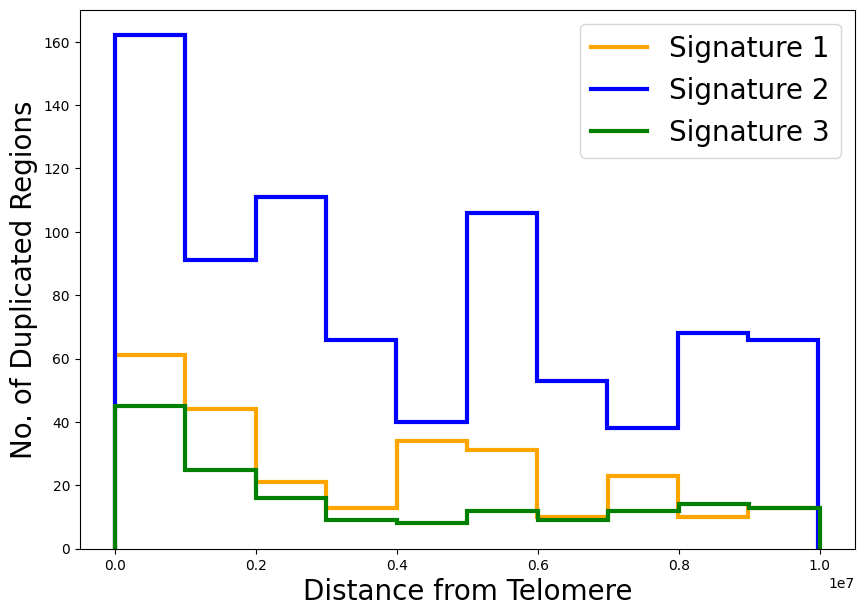

In [236]:

N=11

ind = np.arange(1,N)  
width = 0.35 
 
fig = plt.subplots(figsize =(10, 7))
plt.hist(sig[1], density=False, histtype='step', stacked=True ,label="Signature 1",color="orange",linewidth=3)
plt.hist(sig[0], density=False, histtype='step', stacked=True,label="Signature 2",color="blue",linewidth=3)
plt.hist(sig[2], density=False, histtype='step', stacked=True,label="Signature 3",color="green",linewidth=3)
plt.xlabel("Distance from Telomere",fontsize=20)
plt.ylabel("No. of Duplicated Regions",fontsize=20)

orange_patch = Line2D([0], [0], color='orange',  label='Signature 1',lw=3)
blue_patch = Line2D([0], [0], color='blue',  label='Signature 2',lw=3)
green_patch =Line2D([0], [0], color='green',  label='Signature 3',lw=3)

plt.legend(handles=[orange_patch,blue_patch,green_patch],fontsize=20)


plt.savefig("SD_network/NMF_Analysis/outputs/1MB/dup_vs_telo.pdf",format="pdf")

plt.show()

In [ ]:
proba